# Verify by Cross-Checking with AM

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import src.plot as plot_scheme
import random

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata2/'

my_ozone = Ozone(am_model_data_path=data_path)

nscale_map = my_ozone.data['Nscale']['map']
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * np.exp(nscale_map)

airmass_map = np.exp(my_ozone.data['airmass']['map'])
zenith_map = my_ozone._airmass_to_zenith(airmass_map)

# Randomize which AM generated datafile to use for testing
pwv_idx = random.randint(0, len(pwv_map) - 1)
zenith_idx = random.randint(0, len(zenith_map) - 1)
model_spectrum = my_ozone(pwv_map[pwv_idx], zenith_map[zenith_idx])

start_pwv=pwv_map[0]
end_pwv=pwv_map[1]
zenith_angle=1
points=100

airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(np.exp(airmass_map))
freq_channels = my_ozone.data['freq']['map']

start_zenith=zenith_map[1]
end_zenith=zenith_map[2]
pwv=5
points=100

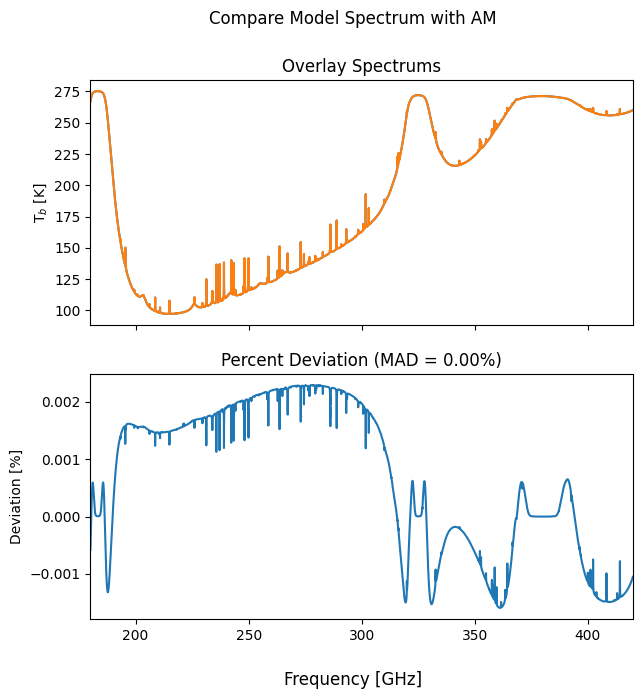

In [4]:
logairmass = 0.001
logNscale = 0.125
filename = f'MaunaKea_Tb_Spectrum_{logairmass:.3f}_{logNscale:+.3f}'
data = np.load(f'{my_ozone.am_model_data_path}{filename}.out')
Tb_data = data[:,2]

zenith_angle = my_ozone._airmass_to_zenith(np.exp(logairmass))
pwv = (np.exp(logNscale))*my_ozone.nominal_pwv
model_spectrum = my_ozone(pwv, zenith_angle)

difference_spectrum = ((model_spectrum - Tb_data) / Tb_data) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

ax1.plot(freq_channels, Tb_data)
ax1.plot(freq_channels, model_spectrum)
ax2.plot(freq_channels, difference_spectrum)

fig.supxlabel("Frequency [GHz]")
fig.suptitle("Compare Model Spectrum with AM")


ax1.set_title(f"Overlay Spectrums")
ax1.set_ylabel(r'T$_b$ [K]')

mad_deviation, max_deviation = np.percentile(difference_spectrum, [50, 99])
ax2.set_title(f"Percent Deviation (MAD = {mad_deviation:.2f}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));


In [2]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

verify_map = np.zeros((my_ozone.data['Nscale']['points'], my_ozone.data['airmass']['points']))

for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        Tb_data = my_ozone.data['Tb_scalar_field'][idx,jdx]
        model_spectrum = my_ozone(pwv_map[idx], zenith_map[jdx])[0][0] 
        comparison = ((model_spectrum - Tb_data) / Tb_data) * 100
        verify_map[idx,jdx] = np.mean(comparison)

Text(0.02, 0.5, 'Deviation [%]')

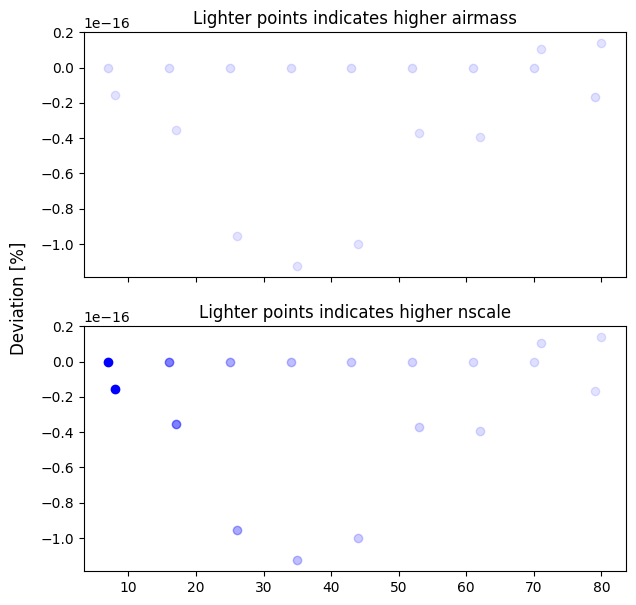

In [4]:
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))

count = 0
for idx, nscale in enumerate(nscale_map):
    for jdx, airmass in enumerate(airmass_map):
        color = mcolors.to_rgba('blue', alpha=1/(jdx+1))
        ax1.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax1.set_title("Lighter points indicates higher airmass")

count = 0
for idx, nscale in enumerate(nscale_map):
    color = mcolors.to_rgba('blue', alpha=1/(idx+1))
    for jdx, airmass in enumerate(airmass_map):
        ax2.scatter(count, verify_map[idx,jdx], color=color)
        count += 1
ax2.set_title("Lighter points indicates higher nscale")

fig.supylabel("Deviation [%]")

# Verify using PWV Jacobian

In [ ]:
# 2mm - 3mm (100 points)
# At each interval point - calc baseline spectrum; grab jacobian; multiply 1/100 to get difference if pwv increase by 1/100
# Add it to the spectrum 2mm PWV
# Repeat until we get to 3mm; cross-check with what the interpolation function spits out for 3mm

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

#data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'

data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata2/'
my_ozone = Ozone(am_model_data_path=data_path)

def jacobian_verify_w_pwv(zenith, start_pwv, end_pwv, freq_channels, points=100, plot=False):
    pwv_map = np.linspace(start_pwv, end_pwv, points)

    base_spectrum, _, _ = my_ozone(start_pwv, zenith)
    expected_spectrum, _, _ = my_ozone(end_pwv, zenith)

    test_spectrum = base_spectrum
    for pwv in pwv_map:
        _, pwv_jacobian, _ = my_ozone(pwv, zenith, return_pwv_jacobian=True, return_model_spectrum=False)
        little_jacobian = pwv_jacobian * ((end_pwv-start_pwv)/points)
        test_spectrum += little_jacobian

    difference_spectrum = ((test_spectrum - expected_spectrum) / expected_spectrum) * 100

    if plot:
        import src.plot as plot_scheme
        plot_scheme.verify_spectrum(test_spectrum, expected_spectrum, difference_spectrum, freq_channels)
                
    return difference_spectrum

(9,) (9,)


-0.03291156392319469

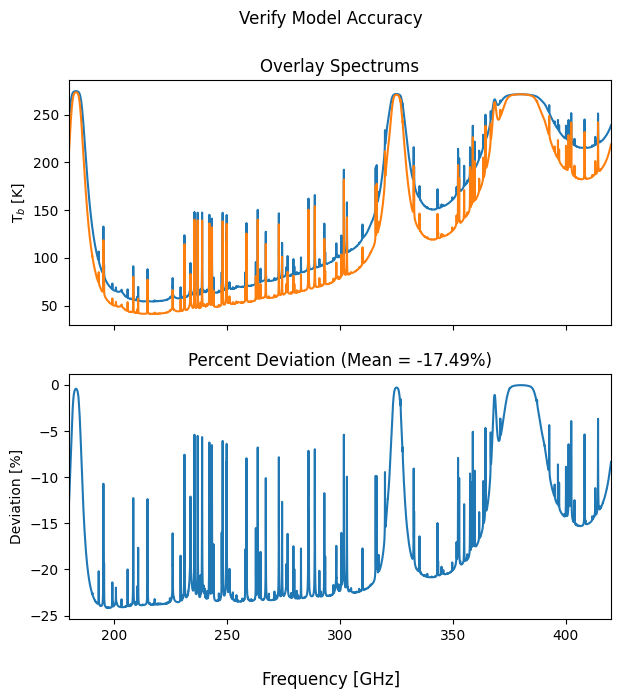

In [3]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = my_ozone.data['freq']['map']

last_pwv=pwv_map[-1]-1
last_zenith=zenith_map[-1]
first_pwv=pwv_map[1]
first_zenith=zenith_map[0]

zenith = 0.1
difference_spectrum = jacobian_verify_w_pwv(zenith, pwv_map[0], pwv_map[1], freq_channels, plot=True, points=100)
print(nscale_map.shape, airmass_map.shape)
np.percentile(difference_spectrum, 99)


In [ ]:
'/Users/namsonnguyen/repo/data/AM_Data/newdata2/'

In [17]:
min_nscale, max_nscale, Nscale_points = -2.0, 2.0, 9
min_airmass, max_airmass, airmass_points = 0.001, 1.281, 32

freq_points = 240001

Nscale_map = np.linspace(min_nscale, max_nscale, Nscale_points)
airmass_map = np.linspace(min_airmass, max_airmass, airmass_points)

Nscale_map
airmass_map

array([1.00000000e-03, 4.22903226e-02, 8.35806452e-02, 1.24870968e-01,
       1.66161290e-01, 2.07451613e-01, 2.48741935e-01, 2.90032258e-01,
       3.31322581e-01, 3.72612903e-01, 4.13903226e-01, 4.55193548e-01,
       4.96483871e-01, 5.37774194e-01, 5.79064516e-01, 6.20354839e-01,
       6.61645161e-01, 7.02935484e-01, 7.44225806e-01, 7.85516129e-01,
       8.26806452e-01, 8.68096774e-01, 9.09387097e-01, 9.50677419e-01,
       9.91967742e-01, 1.03325806e+00, 1.07454839e+00, 1.11583871e+00,
       1.15712903e+00, 1.19841935e+00, 1.23970968e+00, 1.28100000e+00])

In [9]:
pwv_map[0], pwv_map[1], zenith_map[0], zenith_map[1]

(0.213, 0.33758224999421715, 0.04470273766021792, 0.8961647817291455)

In [14]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)

last_pwv=pwv_map[-1]-1
last_zenith=zenith_map[-1]
first_pwv=pwv_map[0]
first_zenith=zenith_map[0]

size = 5
test_pwv_map = np.linspace(first_pwv, last_pwv, size)
test_zenith_map = np.linspace(first_zenith, last_zenith, size)
freq_channels = my_ozone.data['freq']['map']

print(f"Estimated Run Time: {(17*size**2)/60:.1f} min")

max_deviations = np.zeros(shape=(test_pwv_map.size, test_zenith_map.size))
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        start_pwv = pwv
        end_pwv = start_pwv + 1
        max_deviations[idx,jdx] = np.max(jacobian_verify_w_pwv(zenith, start_pwv, end_pwv, freq_channels))

Estimated Run Time: 7.1 min


(-1.0, 1.0)

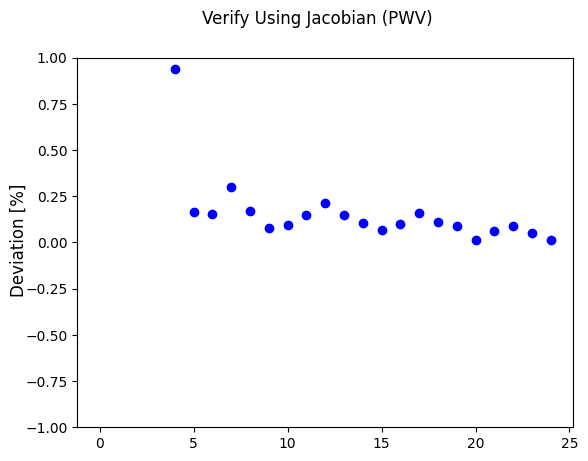

In [15]:
fig, ax = plt.subplots()
x_text = []
count=0
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        x_text.append(f'({pwv:.1f}, {zenith:.1f})')
        ax.scatter(count, max_deviations[idx,jdx], color='blue')
        count+=1

fig.supylabel("Deviation [%]")
fig.suptitle("Verify Using Jacobian (PWV)")

#ax.set_xticks(np.linspace(0, size**2-1, size**2))
#ax.set_xticklabels(x_text)
#plt.xticks(rotation=45, ha='right') 
plt.ylim(-1,1)

# Verify Using Airmass Jacobian

In [8]:
%reload_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/data/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
data_path = '/Users/namsonnguyen/repo/data/AM_Data/newdata/'
my_ozone = Ozone(am_model_data_path=data_path)

def jacobian_verify_w_zenith(pwv, start_zenith, end_zenith, freq_channels, points=100, plot=False):
    zenith_map = np.linspace(start_zenith, end_zenith, points)

    base_spectrum, _, _ = my_ozone(pwv, start_zenith)
    expected_spectrum, _, _ = my_ozone(pwv, end_zenith)

    test_spectrum = base_spectrum
    for zenith in zenith_map:
        _, _, zenith_jacobian = my_ozone(pwv, zenith, return_zenith_jacobian=True, return_model_spectrum=False)
        little_jacobian = zenith_jacobian * ((end_zenith-start_zenith)/points)
        test_spectrum += little_jacobian

    difference_spectrum = ((test_spectrum - expected_spectrum) / expected_spectrum) * 100

    if plot:
        import src.plot as plot_scheme
        plot_scheme.verify_spectrum(test_spectrum, expected_spectrum, difference_spectrum, freq_channels,
                                    title='Verify Using Airmass Jacobian')
                
    return np.mean(difference_spectrum)

#%lprun -f jacobian_verify_w_zenith jacobian_verify_w_zenith(0.213, 0.25, 0.5, my_ozone.data['freq']['map'], plot=True)

0.23552367524418094

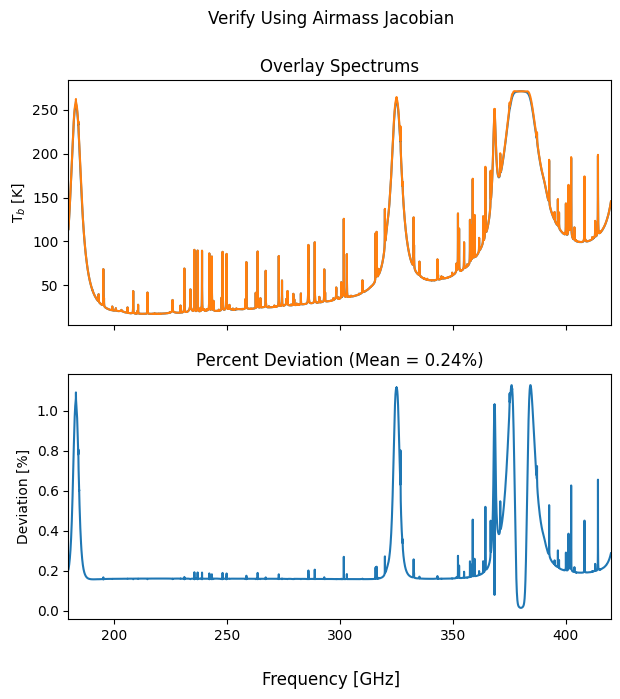

In [9]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)

last_pwv=pwv_map[-1]-1
last_zenith=zenith_map[-1]-0.25
first_pwv=pwv_map[0]
first_zenith=zenith_map[0]

freq_channels = my_ozone.data['freq']['map']

difference_spectrum = jacobian_verify_w_zenith(first_pwv, zenith_map[0], zenith_map[1], freq_channels, plot=True)
np.percentile(difference_spectrum, 99)


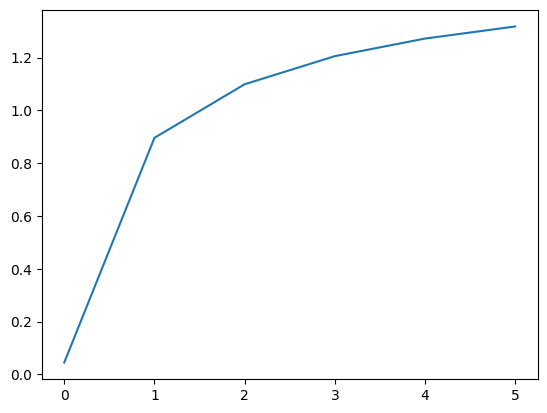

In [18]:
plt.plot(zenith_map)

Estimated Run Time: 7.9 min
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.05
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith -> airmass: 1.00
PWV -> nscale: -1.00
zenith

(-1.0, 1.0)

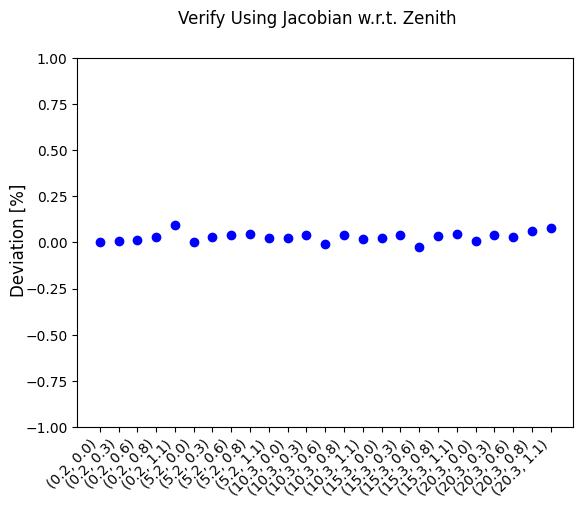

In [17]:
size = 5
test_pwv_map = np.linspace(first_pwv, last_pwv, size)
test_zenith_map = np.linspace(first_zenith, last_zenith, size)
freq_channels = my_ozone.data['freq']['map']

print(f"Estimated Run Time: {(19*size**2)/60:.1f} min")

mean_deviations = np.zeros(shape=(test_pwv_map.size, test_zenith_map.size))
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        start_zenith = zenith
        end_zenith = start_zenith + 0.25
        mean_deviations[idx,jdx] = jacobian_verify_w_zenith(pwv, start_zenith, end_zenith, freq_channels)

fig, ax = plt.subplots()
x_text = []
count=0
for idx, pwv in enumerate(test_pwv_map):
    for jdx, zenith in enumerate(test_zenith_map):
        x_text.append(f'({pwv:.1f}, {zenith:.1f})')
        ax.scatter(count, mean_deviations[idx,jdx], color='blue')
        count+=1

fig.supylabel("Deviation [%]")
fig.suptitle("Verify Using Jacobian w.r.t. Zenith")

ax.set_xticks(np.linspace(0, size**2-1, size**2))
ax.set_xticklabels(x_text)
plt.xticks(rotation=45, ha='right') 
plt.ylim(-1,1)

In [ ]:
# git stash
# git stash pop